## Predicting Games Played until Peak Performance

This project will analyze player statistics from the history of baseball.  During this analysis, we will review the following question:
 - Can we predict the number of games played at which a player will hit their peak performance?

https://github.com/carl-schick-ds/baseball

***
### Setup
Import needed libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [35]:
# Import libraries
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Auto Re-load External Modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
### Data Collection
Data collection was not required for this project since the [original dataset](https://www.kaggle.com/seanlahman/the-history-of-baseball) is available online in SQLite and CSV format from Kaggle.  

A copy of the SQLite database is included in this repository at `./data/mlb_data.sqlite`.  In addition, I developed an [ER diagram](data/mlb_erd.jpg) of the tables used in this analysis.  While these foreign key relationships do not actually exist in the database structure, they are shown illustratively to see the linkages.

### Data Loading and Cleaning

#### Load players, positions, and performance data

In [37]:
# Initiate helper class to manage SQL queries
import baseball_dl as dl
bb_dl = dl.Baseball_Data_Loader()

***
Load player attributes
***

In [38]:
players_df = bb_dl.get_players()

,name,debut,weight,height,bat_hand,throw_hand
player_id,,,,,,
aardsda01,David Aardsma,2004-04-06,220,75,R,R
aaronha01,Hank Aaron,1954-04-13,180,72,R,R
aaronto01,Tommie Aaron,1962-04-10,190,75,R,R
aasedo01,Don Aase,1977-07-26,190,75,R,R
abadan01,Andy Abad,2001-09-10,184,73,L,L


***
Load positions played by each player
***

In [39]:
plyr_pos_df = bb_dl.get_player_positions()

,player_id,catcher,firstbaseman,secondbaseman,thirdbaseman,shortstop,outfielder
0,aardsda01,0,0,0,0,0,0
1,aaronha01,0,210,43,7,0,2760
2,aaronto01,0,232,7,10,0,138
3,aasedo01,0,0,0,0,0,0
4,abadan01,0,8,0,0,0,1


***
Load key performance indicators for each player
***

In [40]:
performance_df = bb_dl.get_player_performance()

,player_id,year,stint,games_yr,at_bats,hits,hr,rbi
0,abercda01,1871,1,1,4,0,0,0
1,addybo01,1871,1,25,118,32,0,13
2,allisar01,1871,1,29,137,40,0,19
3,allisdo01,1871,1,27,133,44,2,27
4,ansonca01,1871,1,25,120,39,0,16


#### Clean and massage player data

In [41]:
# Check for missing data and data structure
print(players_df.isnull().sum())
print(players_df.info())

name          0
debut         0
weight        0
height        0
bat_hand      0
throw_hand    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 18846 entries, aardsda01 to zychto01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        18846 non-null  object
 1   debut       18846 non-null  object
 2   weight      18846 non-null  object
 3   height      18846 non-null  object
 4   bat_hand    18846 non-null  object
 5   throw_hand  18846 non-null  object
dtypes: object(6)
memory usage: 1.0+ MB
None


***
Debut is the date when the player first played a game.  We want to convert this into the player's rookie year.  
Since only 193 of 18,846 players are missing rookie years, we will drop them.
***

In [42]:
players_df['debut'] = pd.to_datetime(players_df['debut'])
players_df['rookie_year'] = players_df['debut'].dt.year
players_df.drop(['debut'] , axis=1, inplace=True)
print("\nNumber of players to drop due to missing rookie years: ", players_df['rookie_year'].isna().sum())

players_df.dropna(subset=['rookie_year'], inplace=True)
players_df['rookie_year'] = players_df['rookie_year'].astype(int)

assert(players_df[players_df['rookie_year'] == '']['rookie_year'].count() == 0)


Number of players to drop due to missing rookie years:  193


***
Since data is represented as strings, let's look for missing values as empty strings.  
Missing heights, weights, batting hand, and throwing hand or mostly from the 1800s.  
As with rookie-year, rows with missing data are nominal, and we will drop them.
***

In [43]:
missing_height_or_weight = (players_df['height'] == '') | (players_df['weight'] == '')
display(players_df[missing_height_or_weight]['rookie_year'].astype(str).str[0:2].value_counts())

missing_bat_or_throw_hand = (players_df['bat_hand'] == '') | (players_df['throw_hand'] == '')
display(players_df[missing_bat_or_throw_hand]['rookie_year'].astype(str).str[0:2].value_counts())

print("\nNumber of players to drop due to missing height or weight: ", players_df[missing_height_or_weight]['name'].count())
print("Number of players to drop due to missing rookie years: ", players_df[missing_bat_or_throw_hand]['name'].count())
players_df = players_df[~missing_height_or_weight & ~missing_bat_or_throw_hand]

players_df['height'] = players_df['height'].astype(int)
players_df['weight'] = players_df['weight'].astype(int)


18    630
19    193
Name: rookie_year, dtype: int64

18    1040
19     161
Name: rookie_year, dtype: int64


Number of players to drop due to missing height or weight:  823
Number of players to drop due to missing rookie years:  1201


***
Confirm batting hand and throwing hand data is as expected.
***

In [44]:
print(players_df['bat_hand'].value_counts())
print(players_df['throw_hand'].value_counts())

R    11346
L     4767
B     1139
Name: bat_hand, dtype: int64
R    13783
L     3469
Name: throw_hand, dtype: int64


***
Final summary.
***

In [45]:
print(players_df.info())
print(players_df.shape)
display(players_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 17252 entries, aardsda01 to zychto01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         17252 non-null  object
 1   weight       17252 non-null  int64 
 2   height       17252 non-null  int64 
 3   bat_hand     17252 non-null  object
 4   throw_hand   17252 non-null  object
 5   rookie_year  17252 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 943.5+ KB
None
(17252, 6)


,name,weight,height,bat_hand,throw_hand,rookie_year
player_id,,,,,,
aardsda01,David Aardsma,220,75,R,R,2004
aaronha01,Hank Aaron,180,72,R,R,1954
aaronto01,Tommie Aaron,190,75,R,R,1962
aasedo01,Don Aase,190,75,R,R,1977
abadan01,Andy Abad,184,73,L,L,2001


#### Clean and massage position data

In [46]:
# Only evaluate players in the player list
player_list = players_df.index.tolist()
plyr_pos_df = plyr_pos_df[plyr_pos_df['player_id'].isin(player_list)]

# Check for missing data and data structure
print(plyr_pos_df.isnull().sum())
print(plyr_pos_df.info())

player_id        0
catcher          0
firstbaseman     0
secondbaseman    0
thirdbaseman     0
shortstop        0
outfielder       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17249 entries, 0 to 18659
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   player_id      17249 non-null  object
 1   catcher        17249 non-null  int64 
 2   firstbaseman   17249 non-null  int64 
 3   secondbaseman  17249 non-null  int64 
 4   thirdbaseman   17249 non-null  int64 
 5   shortstop      17249 non-null  int64 
 6   outfielder     17249 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.1+ MB
None


***
To qualify for inclusion in the analysis, a player needs to have played a primary position for at least one season.  
The number of games in 1 MLB season today (and since 1961) is 162, it was 140 in 1901 and 154 in 1920.  We will use 140 as the threshold.  

Although players tend to play one primary position, they often shift among a few positions.  We will only analysis their "primary position", with "primary position" being defined as the position they spent the most time at over their careers.  For outfielders, shifting between left, right, and center is so common that we will group all outfielders into a single 'outfielder' position.  This grouping was already included in the raw date retrieval.
***

In [47]:
games_played_threshold = 140
positions = ['catcher', 'firstbaseman', 'secondbaseman', 'thirdbaseman', 'shortstop', 'outfielder']
min_games_at_max_pos = plyr_pos_df[positions].max(axis=1) > games_played_threshold
plyr_pos_df = plyr_pos_df[min_games_at_max_pos]

plyr_pos_df['position'] = plyr_pos_df[positions].idxmax(axis=1)

***
Add the player's primary position into the players dataframe.
***

In [48]:
plyr_pos_df.set_index('player_id', inplace=True)
players_df = pd.concat([players_df, plyr_pos_df['position']], axis=1, join='inner')
players_df.head()

,name,weight,height,bat_hand,throw_hand,rookie_year,position
player_id,,,,,,,
aaronha01,Hank Aaron,180,72,R,R,1954,outfielder
aaronto01,Tommie Aaron,190,75,R,R,1962,firstbaseman
abbated01,Ed Abbaticchio,170,71,R,R,1897,secondbaseman
abbeych01,Charlie Abbey,169,68,L,L,1893,outfielder
abbotje01,Jeff Abbott,190,74,R,L,1997,outfielder


#### Clean and massage performance data

In [49]:
# Only evaluate players in the player list
player_list = players_df.index.tolist()
performance_df = performance_df[performance_df['player_id'].isin(player_list)]

# Check for missing data and data structure
print(performance_df.isnull().sum())
print(performance_df.info())

player_id    0
year         0
stint        0
games_yr     0
at_bats      0
hits         0
hr           0
rbi          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45099 entries, 1 to 101330
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   player_id  45099 non-null  object
 1   year       45099 non-null  int64 
 2   stint      45099 non-null  int64 
 3   games_yr   45099 non-null  int64 
 4   at_bats    45099 non-null  object
 5   hits       45099 non-null  object
 6   hr         45099 non-null  object
 7   rbi        45099 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.1+ MB
None


***
The presence of key statistics is vital for our analysis.  We will drop any performance data that is lacking these measures (only .17% of our dataset).
***

In [50]:
missing_key_stats = (performance_df['at_bats'] == '') | (performance_df['hits'] == '') | (performance_df['hr'] == '') | (performance_df['rbi'] == '')

print("\nNumber of players to drop due to missing key statistics: ", performance_df[missing_key_stats]['year'].count())
performance_df = performance_df[~missing_key_stats]


Number of players to drop due to missing key statistics:  76


***
Player performance is commonly evaluated based on three key metrics: batting average, runs batted in, and home runs.  Note that the evaluation for pitchers is based on wins, earned run average, and strikeouts.  We will only examine non-pitchers in this analysis.  

* Batting average (ba): calculated as the number of hits divided by the number of at-bats during a given season.  
* Runs batted in (rbi): retrieved directly from the raw data  
* Home runs (hr): retrieved directly from the raw data  

These three statics are calculated for each players, for each year (or stint/partial-year if the player moved teams).  Since a large sample of at-bats is necessary to compare statistics across players, we will use the common threshold of 502 at-bats in a given season/stint in order for that year to qualify for analysis.
***

In [51]:
# Calculate statistics

at_bats_threshold = 502
performance_df['at_bats'] = performance_df['at_bats'].astype(int)
necessary_at_bats = performance_df['at_bats'] > at_bats_threshold
performance_df = performance_df[necessary_at_bats]

performance_df['hits'] = performance_df['hits'].astype(int)
performance_df['hr'] = performance_df['hr'].astype(int)
performance_df['rbi'] = performance_df['rbi'].astype(int)
performance_df['ba'] = performance_df['hits'] / performance_df['at_bats']

## No Player-Year combo has more than one stint with > 502 at bats; hence we can drop stint
display(performance_df.shape)
display(performance_df['stint'].value_counts())
display(performance_df.groupby(['player_id', 'year']).ngroups)
performance_df.drop(['stint', 'at_bats', 'hits'] , axis=1, inplace=True)

(8440, 9)

1    8407
2      33
Name: stint, dtype: int64

8440

***
Before we find each player's peak performance year, we will calculate the cumulative seasons and cumulative games played at the end of each season.
***

In [52]:
# Add a column to denote the season number for each player's statistics (1..n, where 1 is their first year and n is their last year)
performance_df['season'] = performance_df.groupby(by='player_id')['year'].rank(method='min').astype(int)

# Sort by season, and calculate the cumulative games played after each season
performance_df.sort_values(by=['player_id', 'season'], inplace=True)
performance_df['games'] = performance_df.groupby(by='player_id')['games_yr'].cumsum()
performance_df.head(25)


,player_id,year,games_yr,hr,rbi,ba,season,games
37447,aaronha01,1955,153,27,106,0.313953,1,153
38102,aaronha01,1956,153,26,92,0.328407,2,306
38723,aaronha01,1957,151,44,132,0.321951,3,457
39338,aaronha01,1958,153,30,95,0.326123,4,610
39976,aaronha01,1959,154,39,123,0.354531,5,764
40608,aaronha01,1960,153,40,126,0.291525,6,917
41245,aaronha01,1961,155,34,120,0.326700,7,1072
41943,aaronha01,1962,156,45,128,0.322635,8,1228
42703,aaronha01,1963,161,44,130,0.318542,9,1389
43455,aaronha01,1964,145,24,95,0.328070,10,1534


***
Calculate the total number of seasons played by each player.  This will be included as a feature in our regression analysis.
***

In [53]:
num_seasons_df = pd.DataFrame(performance_df.groupby(by='player_id')['season'].max())
num_seasons_df.rename(columns={'season': 'num_seasons'}, inplace=True)
num_seasons_df.head()

,num_seasons
player_id,
aaronha01,16
abbated01,2
abbeych01,2
abreubo01,11
abreujo02,2


***
We are finally ready to locate the peak-performance year/season for each player.  This is done as follows...
* Rank HRs, RBIs, and BA for each year the player played.  Lower rankings indicate better performance in that category.
* Aggregate the HR/RBI/BA rankings into a single performance level (perf_lvl) ranking.  Again, lower numbers indicate better performance.
* Rank each season the player played based on their performance level for that year.  
* Drop all season except the top ranked season (rank=1).  If more than one season had a ranking of 1, we will keep the latest season as the player's peak performance year.

Once the peak performance year is determined, we add in the total number of season's played for that player and result in a peak_season dataframe.
***

In [54]:
# Rank HRs, RBIs, and BA for each year the player played.  Lower rankings indicate better performance in that category.
performance_df['hr_rank'] = performance_df.groupby(by='player_id')['hr'].rank(method='min', ascending=False).astype(int)
performance_df['rbi_rank'] = performance_df.groupby(by='player_id')['rbi'].rank(method='min', ascending=False).astype(int)
performance_df['ba_rank'] = performance_df.groupby(by='player_id')['ba'].rank(method='min', ascending=False).astype(int)

# Aggregate the HR/RBI/BA rankings into a single performance level (perf_lvl) ranking.  Again, lower numbers indicate better performance.
performance_df['perf_lvl'] = performance_df['hr_rank'] + performance_df['rbi_rank'] + performance_df['ba_rank']

# Rank each season the player played based on their performance level for that year.  
performance_df['perf_rank'] = performance_df.groupby(by='player_id')['perf_lvl'].rank(method='min').astype(int)

# Drop all season except the top ranked season (rank=1).  If more than one season had a ranking of 1, we will keep the latest season as the player's peak performance year.
peak_season = performance_df['perf_rank'] == 1
peak_season_df = performance_df[peak_season]
peak_season_df = peak_season_df.drop_duplicates(subset=['player_id', 'perf_rank'], keep='last')

# Add in the total number of season's played for each player
peak_season_df.set_index('player_id', inplace=True)
peak_season_df = pd.concat([peak_season_df, num_seasons_df], axis=1)

# Final clean-up, removing columns we don't need and renaming others
peak_season_df = peak_season_df[['num_seasons', 'season', 'games']]
peak_season_df.rename(columns={'season': 'peak_season', 'games': 'peak_games'}, inplace=True)
peak_season_df.head(10)

,num_seasons,peak_season,peak_games
player_id,,,
aaronha01,16,8,1228
abbated01,2,2,307
abbeych01,2,1,129
abreubo01,11,6,942
abreujo02,2,1,145
abstebi01,1,1,137
ackledu01,1,1,153
adairje01,3,1,139
adamsbo03,2,2,304


#### Generate the final dataset we will use for modeling: `player_pk_perf_df`.

In [56]:
# Last step: concatenate the players dataframe and the peak_season dataframe, resulting in a dataframe that contains each player's peak performance data.
player_pk_perf_df = pd.concat([players_df, peak_season_df], axis=1, join='inner')
player_pk_perf_df.head(10)

,name,weight,height,bat_hand,throw_hand,rookie_year,position,num_seasons,peak_season,peak_games
player_id,,,,,,,,,,
aaronha01,Hank Aaron,180,72,R,R,1954,outfielder,16,8,1228
abbated01,Ed Abbaticchio,170,71,R,R,1897,secondbaseman,2,2,307
abbeych01,Charlie Abbey,169,68,L,L,1893,outfielder,2,1,129
abreubo01,Bobby Abreu,220,72,L,R,1996,outfielder,11,6,942
abreujo02,Jose Abreu,255,75,R,R,2014,firstbaseman,2,1,145
abstebi01,Bill Abstein,185,72,R,R,1906,firstbaseman,1,1,137
ackledu01,Dustin Ackley,205,73,L,R,2011,secondbaseman,1,1,153
adairje01,Jerry Adair,175,72,R,R,1958,secondbaseman,3,1,139
adamsbo03,Bobby Adams,160,70,R,R,1946,thirdbaseman,2,2,304


### Data Exploration

`TO DO`

### Modeling

In [22]:
min_seasons_mask = player_pk_perf_df['num_seasons'] >= 0
y = player_pk_perf_df[min_seasons_mask]['num_seasons']   ## OR  peak_seasons   OR   peak_games   ** IF num_seasons, drop from X; else keep
X = pd.get_dummies(data=player_pk_perf_df[min_seasons_mask].drop(['name', 'peak_season', 'peak_games', 'num_seasons'] , axis=1), columns=['position','bat_hand', 'throw_hand'], drop_first=True)

display(y)
display(X)

player_id
aaronha01    16
abbated01     2
abbeych01     2
abreubo01    11
abreujo02     2
             ..
zimmehe01     5
zimmery01     6
ziskri01      7
zobribe01     5
zwilldu01     2
Name: num_seasons, Length: 2134, dtype: int64

,weight,height,rookie_year,position_firstbaseman,position_outfielder,position_secondbaseman,position_shortstop,position_thirdbaseman,bat_hand_L,bat_hand_R,throw_hand_R
player_id,,,,,,,,,,,
aaronha01,180,72,1954,0,1,0,0,0,0,1,1
abbated01,170,71,1897,0,0,1,0,0,0,1,1
abbeych01,169,68,1893,0,1,0,0,0,1,0,0
abreubo01,220,72,1996,0,1,0,0,0,1,0,1
abreujo02,255,75,2014,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
zimmehe01,176,71,1907,0,0,0,0,1,0,1,1
zimmery01,220,75,2005,0,0,0,0,1,0,1,1
ziskri01,200,73,1971,0,1,0,0,0,0,1,1


Coefficients: 
 [ 2.75284886e-03  5.52198134e-02  5.24856385e-04  1.50042268e+00
  9.88984936e-01  7.96277995e-01  1.49013607e+00  1.06473106e+00
  9.67875348e-02 -4.48720208e-02 -1.49118420e-01]
Mean squared error: 9.22
Coefficient of determination: 0.01


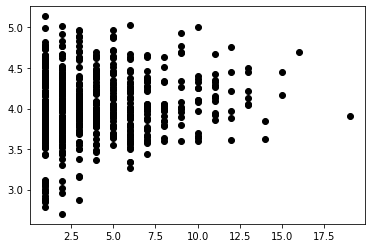

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=77)
regr = LinearRegression()
regr.fit(X_train, y_train)
predictions = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, predictions))

# Plot outputs
plt.scatter(y_test, predictions, color="black")
# plt.ylim(0, 7)

In [24]:
coeff_df = pd.DataFrame(regr.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
weight,0.002753
height,0.055220
rookie_year,0.000525
position_firstbaseman,1.500423
position_outfielder,0.988985
position_secondbaseman,0.796278
position_shortstop,1.490136
position_thirdbaseman,1.064731
bat_hand_L,0.096788
bat_hand_R,-0.044872


In [25]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print("MSE:", metrics.mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.402908819705925
MSE: 9.215253781611153
RMSE: 3.0356636476413446


In [26]:
metrics.explained_variance_score(y_test, predictions)

0.01879657877180385

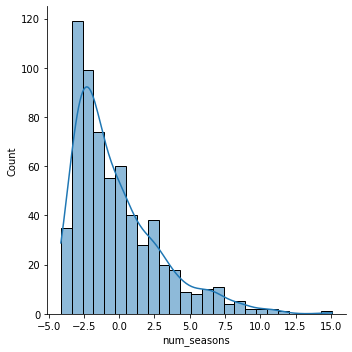

In [27]:
sns.displot(y_test - predictions, bins=25, kde=True);

In [28]:
# test_data_with_pred = X_test.copy()
# test_data_with_pred['pred_peak_season'] = predictions
# test_data_with_pred = pd.concat([player_pk_perf_df.drop(['peak_games'], axis=1), test_data_with_pred['pred_peak_season']], axis=1, join='inner')
# test_data_with_pred['position_group'] = test_data_with_pred['position'].apply(lambda x: 'catcher' if x == 'catcher' else 'outfielder' if x == 'outfielder' else 'infielder')
# test_data_with_pred.head()


In [29]:
# plt.figure(figsize=(25,8))
# sns.set_style('whitegrid')
# palette=dict(catcher='red', outfielder='green', infielder='blue')
# sns.scatterplot(data=test_data_with_pred.sort_values(by=['position_group'], ascending=False), x='peak_season', y='pred_peak_season', hue='position_group', s=200, palette=palette)
# ''

In [30]:
# test_data_with_pred = X_test.copy()
# test_data_with_pred['pred_peak_games'] = predictions
# test_data_with_pred = pd.concat([player_pk_perf_df.drop(['peak_season'], axis=1), test_data_with_pred['pred_peak_games']], axis=1, join='inner')
# test_data_with_pred['position_group'] = test_data_with_pred['position'].apply(lambda x: 'catcher' if x == 'catcher' else 'outfielder' if x == 'outfielder' else 'infielder')
# test_data_with_pred.head()

In [31]:
# plt.figure(figsize=(25,8))
# sns.set_style('whitegrid')
# palette=dict(catcher='red', outfielder='green', infielder='blue')
# sns.scatterplot(data=test_data_with_pred.sort_values(by=['position_group'], ascending=False), x='peak_games', y='pred_peak_games', hue='position_group', s=200, palette=palette)
# ''

In [32]:
test_data_with_pred = X_test.copy()
test_data_with_pred['pred_num_seasons'] = predictions
test_data_with_pred = pd.concat([player_pk_perf_df.drop(['peak_season', 'peak_games'], axis=1), test_data_with_pred['pred_num_seasons']], axis=1, join='inner')
test_data_with_pred['position_group'] = test_data_with_pred['position'].apply(lambda x: 'catcher' if x == 'catcher' else 'outfielder' if x == 'outfielder' else 'infielder')
test_data_with_pred.head()

,name,weight,height,bat_hand,throw_hand,rookie_year,position,num_seasons,pred_num_seasons,position_group
player_id,,,,,,,,,,
adamsbu01,Buster Adams,180,72,R,R,1939,outfielder,2,3.873362,outfielder
aikenwi01,Willie Aikens,220,75,L,R,1977,firstbaseman,1,4.822177,infielder
alexada01,Dale Alexander,210,75,R,R,1929,firstbaseman,3,4.627796,infielder
alfoned01,Edgardo Alfonzo,210,71,R,R,1995,thirdbaseman,6,4.005865,infielder
alicelu01,Luis Alicea,165,69,B,R,1988,secondbaseman,1,3.544292,infielder


''

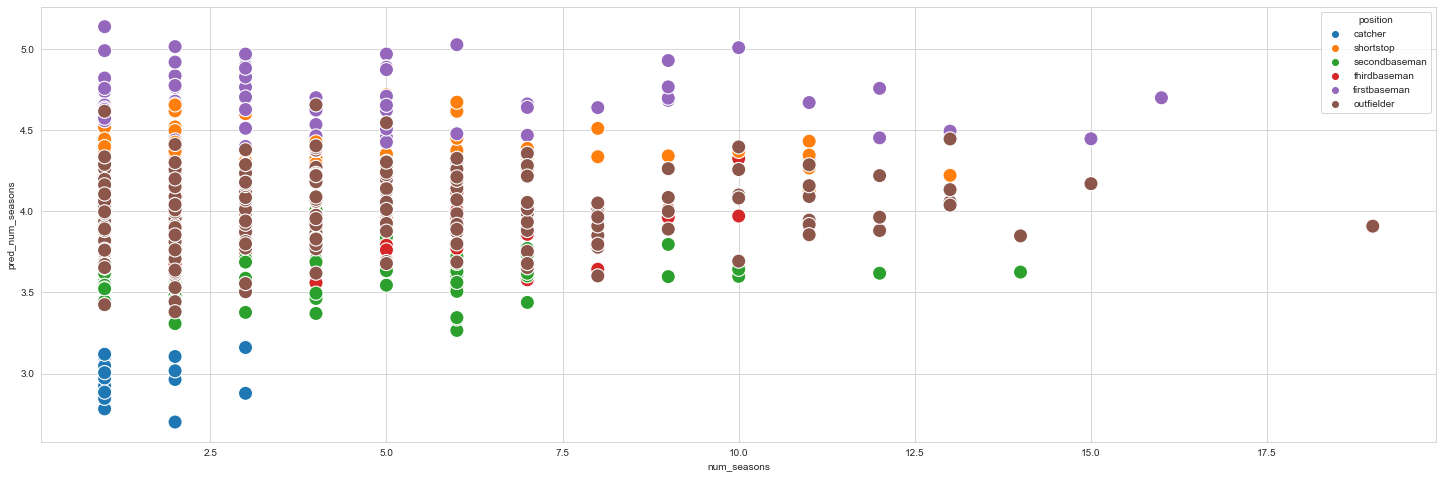

In [33]:
plt.figure(figsize=(25,8))
sns.set_style('whitegrid')
# palette=dict(catcher='red', outfielder='green', infielder='blue')
# sns.scatterplot(data=test_data_with_pred.sort_values(by=['position_group']), x='num_seasons', y='pred_num_seasons', hue='position_group', s=200, palette=palette)
sns.scatterplot(data=test_data_with_pred.sort_values(by=['position_group']), x='num_seasons', y='pred_num_seasons', hue='position', s=200)
''